<a href="https://colab.research.google.com/github/hyx010226/Computer-Vision-Project/blob/Lego-Sorter/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1> <b> Object Detection Using YOLO <b> </h1></center>

This tutorial is designed to provide a comprehensive understanding of how to use YOLO, a state-of-the-art method in computer vision, for detecting objects in images.

Object detection and classification is a key technology in many areas, such as automated vehicles, security, and even healthcare.

We will begin with the basics of preparing (pre processing) an image dataset, ensuring it is ready for effective model training.We will then explore how YOLO, a type of convolutional neural network, automatically extracts features from images to recognize different objects. Understanding this process is crucial for grasping how YOLO operates.

The core of this tutorial is focused on transfer learning using YOLO. We will teach you how to take a pre-trained YOLO model and adapt it to a new dataset. This technique is efficient and powerful, allowing us to harness the strengths of YOLO with less computational effort.

By the end of this tutorial, you will have hands-on experience with preparing data, implementing YOLO, and understanding the principles behind it. This tutorial aims to equip students with practical skills and knowledge in one of the most exciting fields in technology.

Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed.  In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.

In the previous lecture, you were asked to make your own custom datasets for a project you want to work on. Today we will explore how to finetune YOLO on a certain dataset.  

Importing required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

# Dataset Description






Fruit Images for Object Detection

available on kaggle => https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection


- 240 images in train folder. 60 images in test folder.

- 3 different fruits:

    - Apple

    - Banana

    - Orange

The labels are in xml format, which is Extensible markup language.Storing image dataset labels in XML format is quite common. XML provides a clear, hierarchical structure which is ideal for representing the complex data associated with image labels. This includes not just the class of the object, but potentially a wealth of other information like bounding box coordinates, object IDs, and additional metadata.


# Data Preprocessing

For preprocessing:
- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO
  - Labels format should be darknet YOLO.
  - Labels files should be .txt files
- Check and see if there are any missing labels or images. And remove them from dataset.


## Heirarchy of Folders correction

Defining paths to train and test folders.

In [ ]:
test_dir = '/content/drive/MyDrive/CVP/Dataset/Test'
train_dir = '/content/drive/MyDrive/CVP/Dataset/Train'



The train and test folders have all the images and labels together.

But for YOLO, the directories should be in:

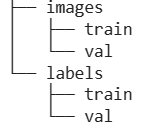


Making directories according to above struture of folders

In [ ]:
import os
#run it once for making directories

os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/images')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/labels')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/images/train')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/images/val')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/labels/train')
os.makedirs('/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/labels/val')

FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data'

In [ ]:
#set the paths to labels and images directory
label_dir= "/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/labels"
image_dir="/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/images"

Copy XML files and jpg files from the train folder to the folders created.

In [ ]:
import shutil
#run it once for copying!
for file in os.listdir(train_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(train_dir, file), os.path.join(label_dir, "train"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"train", new_filename), "JPEG")
        #shutil.copy(os.path.join(train_dir, file), os.path.join(image_dir, "train"))


#Copy XML files and jpg files from the test folder to the folders created.
for file in os.listdir(test_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(test_dir, file), os.path.join(label_dir, "val"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(test_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir,"val", new_filename), "JPEG")
        #shutil.copy(os.path.join(test_dir, file), os.path.join(image_dir, "val"))


Visualizing somme pictures from the dataset

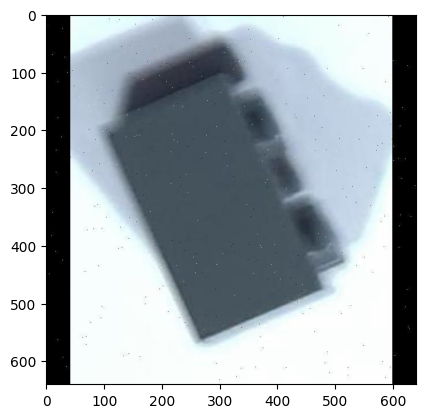

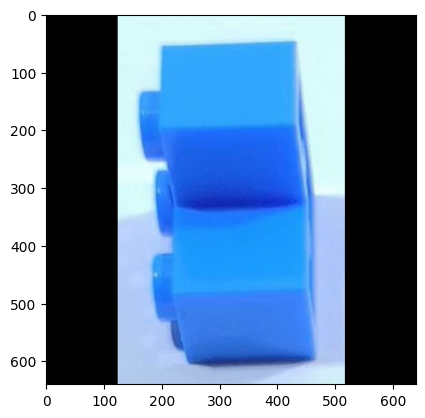

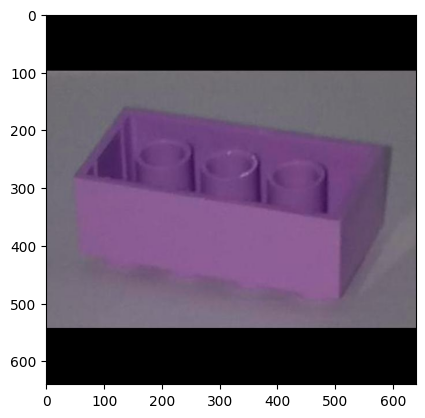

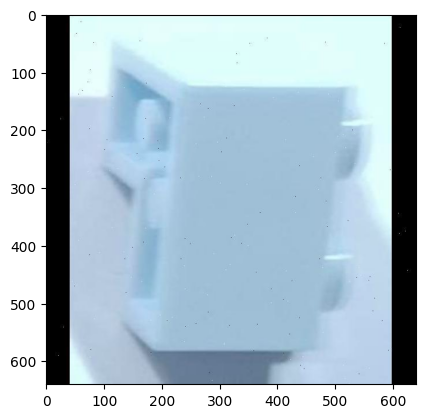

In [ ]:
#visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir,"train", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

## Creating Text files for labels
Creating Dataframes from .xml files, from which we will eventually create .txt file for each image


In [ ]:
#import glob
#import xml.etree.ElementTree as ET

df = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir+"/train" + '/*.xml')):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    df['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

流式输出内容被截断，只能显示最后 5000 行内容。
<Element 'occluded' at 0x7e2334e87ce0>
<Element 'bndbox' at 0x7e2332cb0ae0>
<Element 'xmin' at 0x7e2332cb1030>
<Element 'xmax' at 0x7e2332cb2d90>
<Element 'ymin' at 0x7e2332cb0b30>
<Element 'ymax' at 0x7e2334e53060>
/content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/labels/train/c5_6_2okS_original_3001_1609710790096_jpg.rf.7f33811b4812cbef9e2c27a1ea09d401.xml
<Element 'annotation' at 0x7e2334f95350>
<Element 'folder' at 0x7e2332da3fb0>
<Element 'filename' at 0x7e2332da3e20>
<Element 'path' at 0x7e2332da3f10>
<Element 'source' at 0x7e2332da3d80>
<Element 'database' at 0x7e2332da3ec0>
<Element 'size' at 0x7e2332da3c90>
<Element 'width' at 0x7e2332da0090>
<Element 'height' at 0x7e2332da3e70>
<Element 'depth' at 0x7e2332da3ce0>
<Element 'segmented' at 0x7e2332da3d30>
<Element 'object' at 0x7e2332da3f60>
<Element 'name' at 0x7e23c079b240>
<Element 'pose' at 0x7e2334dc5490>
<Element 'truncated' at 0x7e2334dc6610>
<Element 'difficult' at 0x7e2334f8bfb0>


Doing the same for validation data labels.


In [ ]:
#import glob
#import xml.etree.ElementTree as ET

df2 = {'name': [],
      'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}


#This is the way to handle xml format files which are in heirarchial form (tees).

for idx, anno in enumerate(glob.glob(label_dir+"/val" + '/*.xml')):

    trees = ET.parse(anno)

    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        #print(item)

        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width =int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))

        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df2['label'] += [label]
                    df2['width'] += [width]
                    df2['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]]
                    df2['name'] += [anno.split('/')[-1][0:-4]]

                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df2['xmin'] += [xmin]

                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df2['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df2['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df2['ymax'] += [ymax]

In [ ]:
import pandas as pd
train_df = pd.DataFrame(df)
val_df=pd.DataFrame(df2)
#df1.head()
val_df.head()

name  label  width  height  xmin  ymin  xmax  ymax
0  d5ff67e0-IMG_3473  15573   3024    4032   620  1163  2361  2861
1  d419101e-IMG_3468   3024   3024    4032   956  1277  2233  2604
2  efe80d2d-IMG_3460   3024   3024    4032   827  1241  2218  2689
3  fc9c330b-IMG_3470  26604   3024    4032   913  1363  2218  2611
4  f3db3beb-IMG_3469   3024   3024    4032   949  1284  2212  2675

Visualizing one of the image in train set with the bounding box

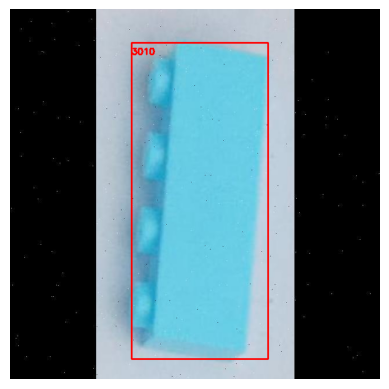

In [ ]:
index= 10 #picture to visualize

#import cv2
image = cv2.imread(os.path.join(image_dir,"train", train_df["name"][index]+".jpg"), 1)
# Draw rectangle
cv2.rectangle(image, (train_df['xmin'][index], train_df['ymin'][index]), (train_df['xmax'][index], train_df['ymax'][index]), (255, 0, 0), 2)
# Put label (class_id) near the bbox
label = train_df["label"][index]
cv2.putText(image, str(label), (train_df['xmin'][index], train_df['ymin'][index]+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)
# Display image
plt.imshow(image)
plt.axis('off')
plt.show()

Checking to see if the above image has bounding boxes around other apples or not.

In [ ]:
train_df["name"][index]
filtered_df = train_df[train_df['name'] == train_df["name"][index]]
print(filtered_df)

                                                 name label  width  height  \
10  c20_15_pcXE_original_3010_1609804680788_jpg.rf...  3010    640     640   

    xmin  ymin  xmax  ymax  
10   210    58   446   605  


Checking to see the datatypes of all the columns and if there is any null value that needs to be eliminated from the data.

In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    62 non-null     object
 1   label   62 non-null     object
 2   width   62 non-null     int64 
 3   height  62 non-null     int64 
 4   xmin    62 non-null     int64 
 5   ymin    62 non-null     int64 
 6   xmax    62 non-null     int64 
 7   ymax    62 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 4.0+ KB


What different types of labels are assigned to each sample and checking if they match the provided label/class information, i.e. there are no extra labels due to mistakes in spellings etc.

In [ ]:
print(train_df['label'].unique())
print(val_df['label'].unique())

['3460' '3001' '3004' '3010' '2357' '3003' '3023' '3020' '3022' '3024'
 '15573' '26604']
['15573' '3024' '26604' '3022' '2730' '2420' '2357' '3003' '3023' '2419'
 '3001']


We need to map labels to class_ids required for YOLO

In [ ]:
label_map = { '2357': 0,
            '2419': 1,
            '2420': 2,
            '2730': 3,
            '3001': 4,
            '3003': 5,
            '3004': 6,
            '3010': 7,
            '3020': 8,
            '3022': 9,
            '3023': 10,
            '3024': 11,
            '3460': 12,
            '26604': 13,
            '15573': 14 }

train_df['class'] = train_df['label'].map(label_map)
val_df['class'] = val_df['label'].map(label_map)

In [ ]:
train_df.head()

name label  width  height  \
0                                  2293b83c-IMG_3465  3460   4032    3024   
1  c5_6_2gOH_original_3001_1609710794206_jpg.rf.f...  3001    640     640   
2  c6_8_JoOr_original_3004_1609704403276_jpg.rf.7...  3004    640     640   
3  c6_7_sp7t_original_3010_1609804820073_jpg.rf.8...  3010    640     640   
4  c5_6_sB5I_original-Bs5_1620809524583_jpg.rf.93...  2357    640     640   

   xmin  ymin  xmax  ymax  class  
0   267   685  3703  2247     12  
1    43   144   600   484      4  
2    50    77   586   536      6  
3   187    39   464   596      7  
4   159    43   473   610      0

convertig the bounding box format to the one required by YOLO:




In [ ]:
# Training data
train_df['x_center'] = (train_df['xmin']+train_df['xmax'])/(2*train_df["width"])
train_df['y_center'] = (train_df['ymin']+train_df['ymax'])/(2*train_df["height"])
train_df['box_width'] = (train_df['xmax']-train_df['xmin'])/ train_df["width"]
train_df['box_height'] = (train_df['ymax']-train_df['ymin'])/train_df["height"]

#Validation data
val_df['x_center'] = (val_df['xmin']+val_df['xmax'])/(2*val_df["width"])
val_df['y_center'] = (val_df['ymin']+val_df['ymax'])/(2*val_df["height"])
val_df['box_width'] = (val_df['xmax']-val_df['xmin'])/ val_df["width"]
val_df['box_height'] = (val_df['ymax']-val_df['ymin'])/val_df["height"]

In [ ]:
train_df.head()

name label  width  height  \
0                                  2293b83c-IMG_3465  3460   4032    3024   
1  c5_6_2gOH_original_3001_1609710794206_jpg.rf.f...  3001    640     640   
2  c6_8_JoOr_original_3004_1609704403276_jpg.rf.7...  3004    640     640   
3  c6_7_sp7t_original_3010_1609804820073_jpg.rf.8...  3010    640     640   
4  c5_6_sB5I_original-Bs5_1620809524583_jpg.rf.93...  2357    640     640   

   xmin  ymin  xmax  ymax  class  x_center  y_center  box_width  box_height  
0   267   685  3703  2247     12  0.492312  0.484788   0.852183    0.516534  
1    43   144   600   484      4  0.502344  0.490625   0.870313    0.531250  
2    50    77   586   536      6  0.496875  0.478906   0.837500    0.717187  
3   187    39   464   596      7  0.508594  0.496094   0.432812    0.870313  
4   159    43   473   610      0  0.493750  0.510156   0.490625    0.885938

Deleting all the sample with Nan values in training and validation data

In [ ]:
#training
print("before deleting (train data): " , train_df.shape)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("after deleting(train_data): " ,train_df.shape)

#validation
print("before deleting (val data): " , val_df.shape)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.dropna(inplace=True)
print("after deleting(val data): " , val_df.shape)



before deleting (train data):  (261, 13)
after deleting(train_data):  (261, 13)
before deleting (val data):  (62, 13)
after deleting(val data):  (62, 13)


converting the dataframe to type *str* (string) to be stored in text files.

In [ ]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

If there are more than one bounding boxes in single image, they should be written in one text file. As, you can see in the below example that one image has so many bounding boxes.

In [ ]:
filtered_df = train_df[train_df['name'] == train_df["name"][100]]
(filtered_df.head(15))

name label width height  \
100  c27_15_pcXE_original_3010_1609804680788_jpg.rf...  3010   640    640   

    xmin ymin xmax ymax class   x_center   y_center box_width box_height  
100  208   47  426  611     7  0.4953125  0.5140625  0.340625    0.88125

In [ ]:
#file_name = [x.split('.')[0] for x in df1["name"]]

#TRAINING DATA
#finding all the unique names:
unique_names= train_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = train_df[train_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/train/{name}.txt', 'w') as file:
            file.write(text)
#############################################################################################
#VALIDATION DATA
#finding all the unique names:
unique_names= val_df['name'].unique()

#for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
  data = val_df[val_df.name == name]
  box_list = []
  for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(row['class']+" "+row['x_center']+" "+row['y_center']+" "+ row['box_width']+" "+row['box_height'])

#writing on text files
  text = "\n".join(box_list)
  with open(f'{label_dir}/val/{name}.txt', 'w') as file:
            file.write(text)

## Checking Missing Files

Checking the folders if every image file has a corresponding label file


(We will copy the code, we already used in previous turorial after updating)

In [ ]:
#The lists of all the images and labels for train and validation set:
train_images=glob.glob(os.path.join(image_dir, "train",'*.jpg'))
train_labels=glob.glob(os.path.join(label_dir, "train",'*.txt'))
val_images=glob.glob(os.path.join(image_dir, "val",'*.jpg'))
val_labels=glob.glob(os.path.join(label_dir, "val",'*.txt'))
#print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
#print(image_files_val)



In [ ]:
print(len(image_files_val), "  =  ", len(label_files_val))

57   =   62


In [ ]:
# Find extra files in each folder

#TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


#VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): set()
Training Extra labels (without corresponding images): {'97d6c548-IMG_3467', 'c4_15_pcXE_original_3010_1609804680788_jpg', '9e0e1cb9-IMG_3459', '3a1fa9ab-IMG_3463', '59b61250-IMG_3457', '5f44db5c-IMG_3464', '1e8d1810-IMG_3478', '8b464eac-IMG_3455', '6eda9d73-IMG_3479', '620fe170-IMG_3471', '0d06d09f-IMG_3458', '59f7f7e5-IMG_3474', '119c465d-IMG_3456', '9f95e4a5-IMG_3477', '3fb7e571-IMG_3472', '3ce44c15-IMG_3466', '4b625976-IMG_3454', '469ff4dc-IMG_3475', '2293b83c-IMG_3465', '99e310e2-IMG_3449', '59ce3092-IMG_3447'}
Validation Extra images (without corresponding labels): set()
Validation Extra labels (without corresponding images): {'fc9c330b-IMG_3470', 'f3db3beb-IMG_3469', 'd419101e-IMG_3468', 'd5ff67e0-IMG_3473', 'efe80d2d-IMG_3460'}


Make sure that the above info is correct by chceking the data manually.

Now removing from the dataset:

In [ ]:
for file in extra_images_train:
     os.remove(os.path.join(image_dir, "train", file + '.jpg')) # or '.png' depending on your image format

for file in extra_images_val:
     os.remove(os.path.join(image_dir, "val", file + '.jpg'))

Now run the above cells again to find if all the missing data is deleted.

# Custom object detection using YOLO

First install and import

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/235.7 GB disk)


In [ ]:
from ultralytics import YOLO

## Training YOLO

We are going to select small pretrained (on COCO dataset) model of YOLOv8

In [ ]:
model = YOLO('yolov8s.pt') # pretrained model

The detailed architecture of the model can be seen from:


In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [ ]:
%%writefile config.yaml
path: /content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data
train: //content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/images/train
#test: (test dataset folder path)
val: /content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/images/val

# Classes
nc: 15 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: 2357
  1: 2419
  2: 2420
  3: 2730
  4: 3001
  5: 3003
  6: 3004
  7: 3010
  8: 3020
  9: 3022
  10: 3023
  11: 3024
  12: 3460
  13: 26604
  14: 15573

Overwriting config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.

In [ ]:
model.train(data="config.yaml",epochs=20,patience=5,batch=8, lr0=0.0005,imgsz=800)

New https://pypi.org/project/ultralytics/8.3.28 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train8/weights/best.pt, data=config.yaml, epochs=20, time=None, patience=5, batch=8, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fal

train: Scanning /content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/labels/train.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/labels/val.cache... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<?, ?it/s]


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 2 dataloader workers
Logging results to runs/detect/train9
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.97G      2.603      4.167      2.732         24        800: 100%|██████████| 30/30 [00:08<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all         57         57    0.00178       0.26     0.0246    0.00735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       4.1G      1.718      3.173      2.082         19        800: 100%|██████████| 30/30 [00:13<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]

                   all         57         57      0.763      0.125      0.079     0.0264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.08G      1.342      2.647      1.823         19        800: 100%|██████████| 30/30 [00:07<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.36it/s]

                   all         57         57    0.00409      0.603      0.107     0.0518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      3.98G      1.045      2.454       1.62         15        800: 100%|██████████| 30/30 [00:12<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all         57         57      0.606      0.104      0.126     0.0792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      3.98G     0.9539      2.151      1.523         25        800: 100%|██████████| 30/30 [00:12<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

                   all         57         57      0.782      0.188      0.186      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       4.1G     0.8845      2.133      1.476         18        800: 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.45it/s]

                   all         57         57      0.468      0.208      0.145     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       4.1G      0.847      1.943      1.473         22        800: 100%|██████████| 30/30 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.83it/s]

                   all         57         57      0.448      0.388      0.151      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      3.98G     0.7989      1.844      1.415         17        800: 100%|██████████| 30/30 [00:12<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all         57         57      0.589      0.312      0.159      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      3.98G      0.719      1.696      1.363         24        800: 100%|██████████| 30/30 [00:08<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

                   all         57         57      0.509      0.254      0.162      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       4.1G     0.7215      1.692      1.381         20        800: 100%|██████████| 30/30 [00:10<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all         57         57      0.529      0.403      0.214      0.194


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      3.98G      1.178       2.76      1.776          8        800: 100%|██████████| 30/30 [00:09<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.88it/s]

                   all         57         57      0.624      0.312      0.233      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      3.98G     0.9692      2.662       1.68          8        800: 100%|██████████| 30/30 [00:11<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all         57         57      0.591      0.333      0.201      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      3.98G     0.8773      2.397      1.646          8        800: 100%|██████████| 30/30 [00:08<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

                   all         57         57      0.643      0.312      0.205      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.11G     0.7891       2.24      1.587          8        800: 100%|██████████| 30/30 [00:10<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all         57         57      0.648      0.188       0.21      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       4.1G     0.7217      2.126      1.559          8        800: 100%|██████████| 30/30 [00:08<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


                   all         57         57      0.533      0.421      0.201      0.162

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      3.98G     0.6109       1.89      1.428          8        800: 100%|██████████| 30/30 [00:09<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]

                   all         57         57      0.523       0.41      0.198       0.17
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 11, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



16 epochs completed in 0.061 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 22.6MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,131,389 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


                   all         57         57      0.625      0.312      0.233      0.218
                  2357          1          1     0.0687          1      0.142      0.142
                  2419         16         16          1          0          0          0
                  2420         12         12          1          0          0          0
                  2730         10         10          1          0          0          0
                  3001          1          1      0.141          1      0.497      0.497
                  3003          2          2      0.788        0.5      0.562      0.555
                  3022          9          9          1          0      0.481      0.433
                  3023          6          6          0          0      0.181      0.112
Speed: 0.7ms preprocess, 10.5ms inference, 0.0ms loss, 7.5ms postprocess per image
Results saved to runs/detect/train9


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  9, 10])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e222c4486a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0

## Evaluation Metrics

[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.

**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category
metrics.box.mp    # P
metrics.box.mr    # R

Ultralytics 8.3.27 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11,131,389 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning /content/drive/MyDrive/Tutorials/Datasets/LEGO DATA/Final_data/labels/val.cache... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]


                   all         57         57      0.625      0.312      0.233      0.217
                  2357          1          1      0.068          1      0.142      0.142
                  2419         16         16          1          0          0          0
                  2420         12         12          1          0          0          0
                  2730         10         10          1          0          0          0
                  3001          1          1      0.141          1      0.497      0.497
                  3003          2          2       0.79        0.5      0.562      0.555
                  3022          9          9          1          0      0.478      0.431
                  3023          6          6          0          0      0.181      0.112
Speed: 1.8ms preprocess, 19.5ms inference, 0.0ms loss, 11.1ms postprocess per image
Results saved to runs/detect/train92


0.3125

Showing confusion matrix, that is already stored in detect/train folder

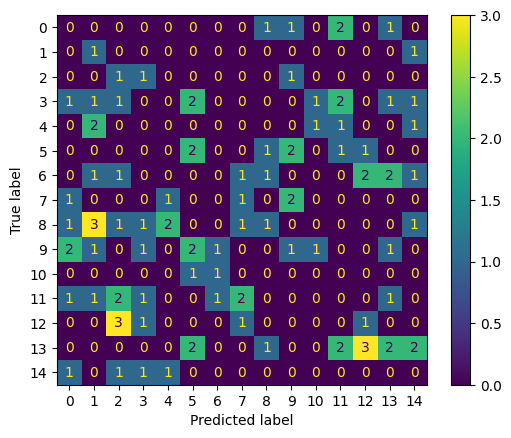

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install matplotlib

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np  # Import numpy for array operations

# Assuming 'y_true' and 'y_pred' are your true and predicted labels respectively.
# If not available, retrieve or compute these from your model and data.

# Generate confusion matrix data (replace with actual values)
y_true = np.random.randint(0, 15, size=100)  # Example true labels
y_pred = np.random.randint(0, 15, size=100)  # Example predicted labels
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Save the confusion matrix to a file
disp.figure_.savefig('/content/runs/detect/train92/confusion_matrix_normalized.png')

##Prediction

In [ ]:
model = YOLO('/content/runs/detect/train9/weights/best.pt')  # load a custom model

# Predict with the model with any image from internet?
results = model('https://i.imgur.com/kU4nq5M.jpeg', save=True)


Found https://i.imgur.com/kU4nq5M.jpeg locally at kU4nq5M.jpeg
image 1/1 /content/kU4nq5M.jpeg: 800x608 (no detections), 22.4ms
Speed: 17.4ms preprocess, 22.4ms inference, 6.3ms postprocess per image at shape (1, 3, 800, 608)
Results saved to runs/detect/predict8


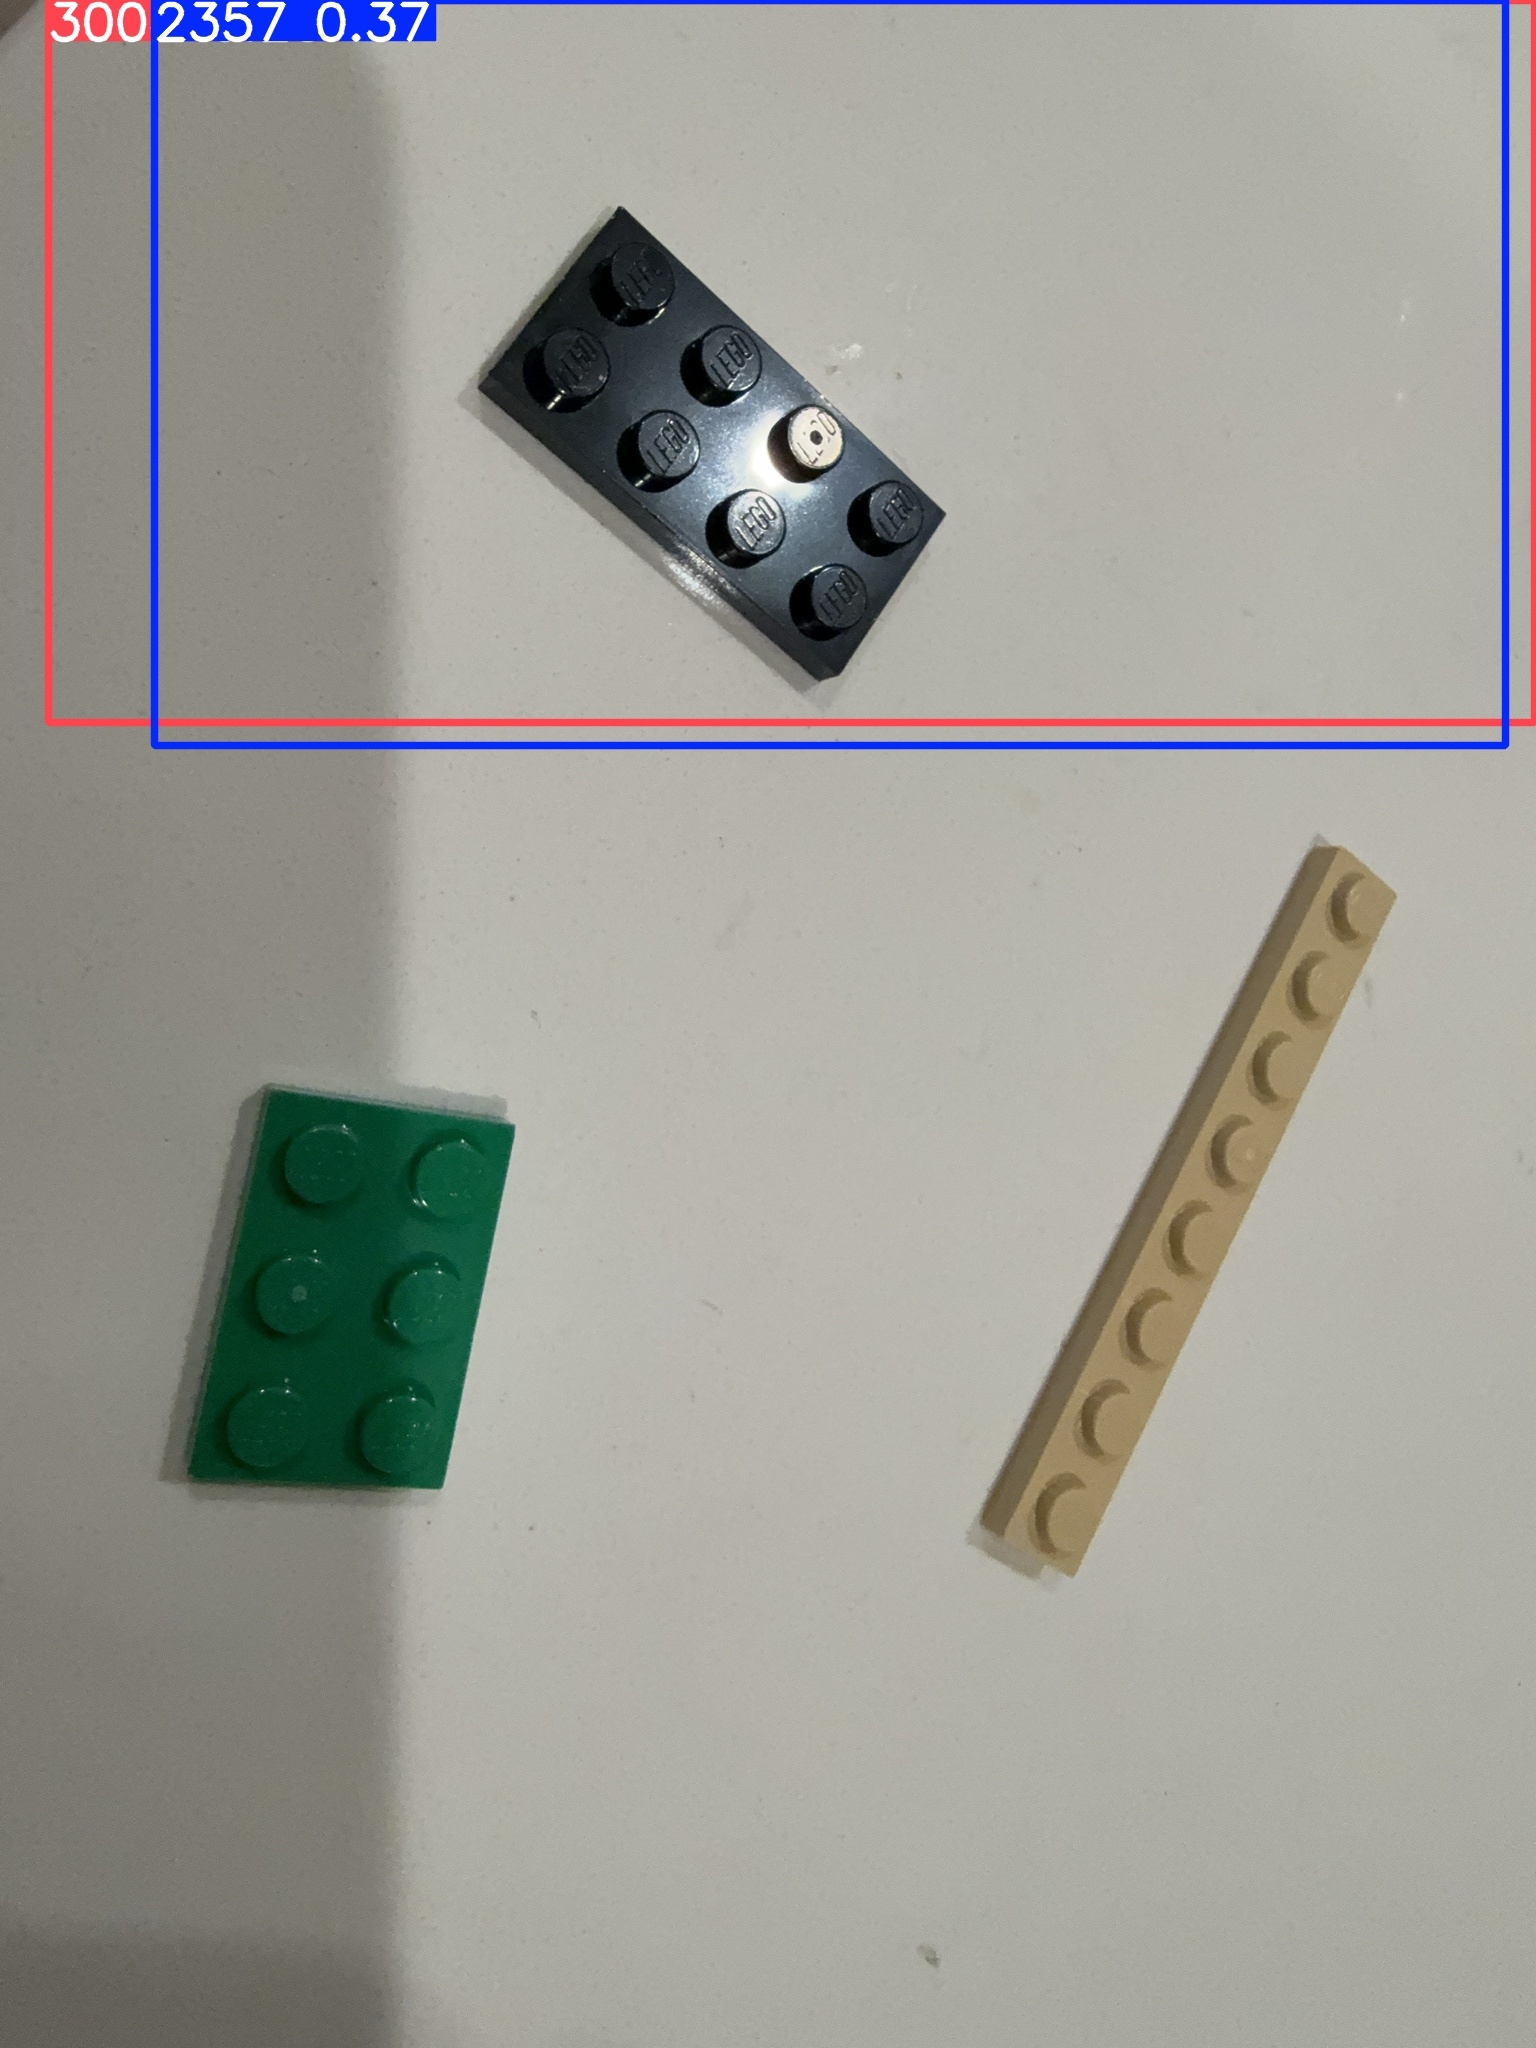

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict7/kU4nq5M.jpg')

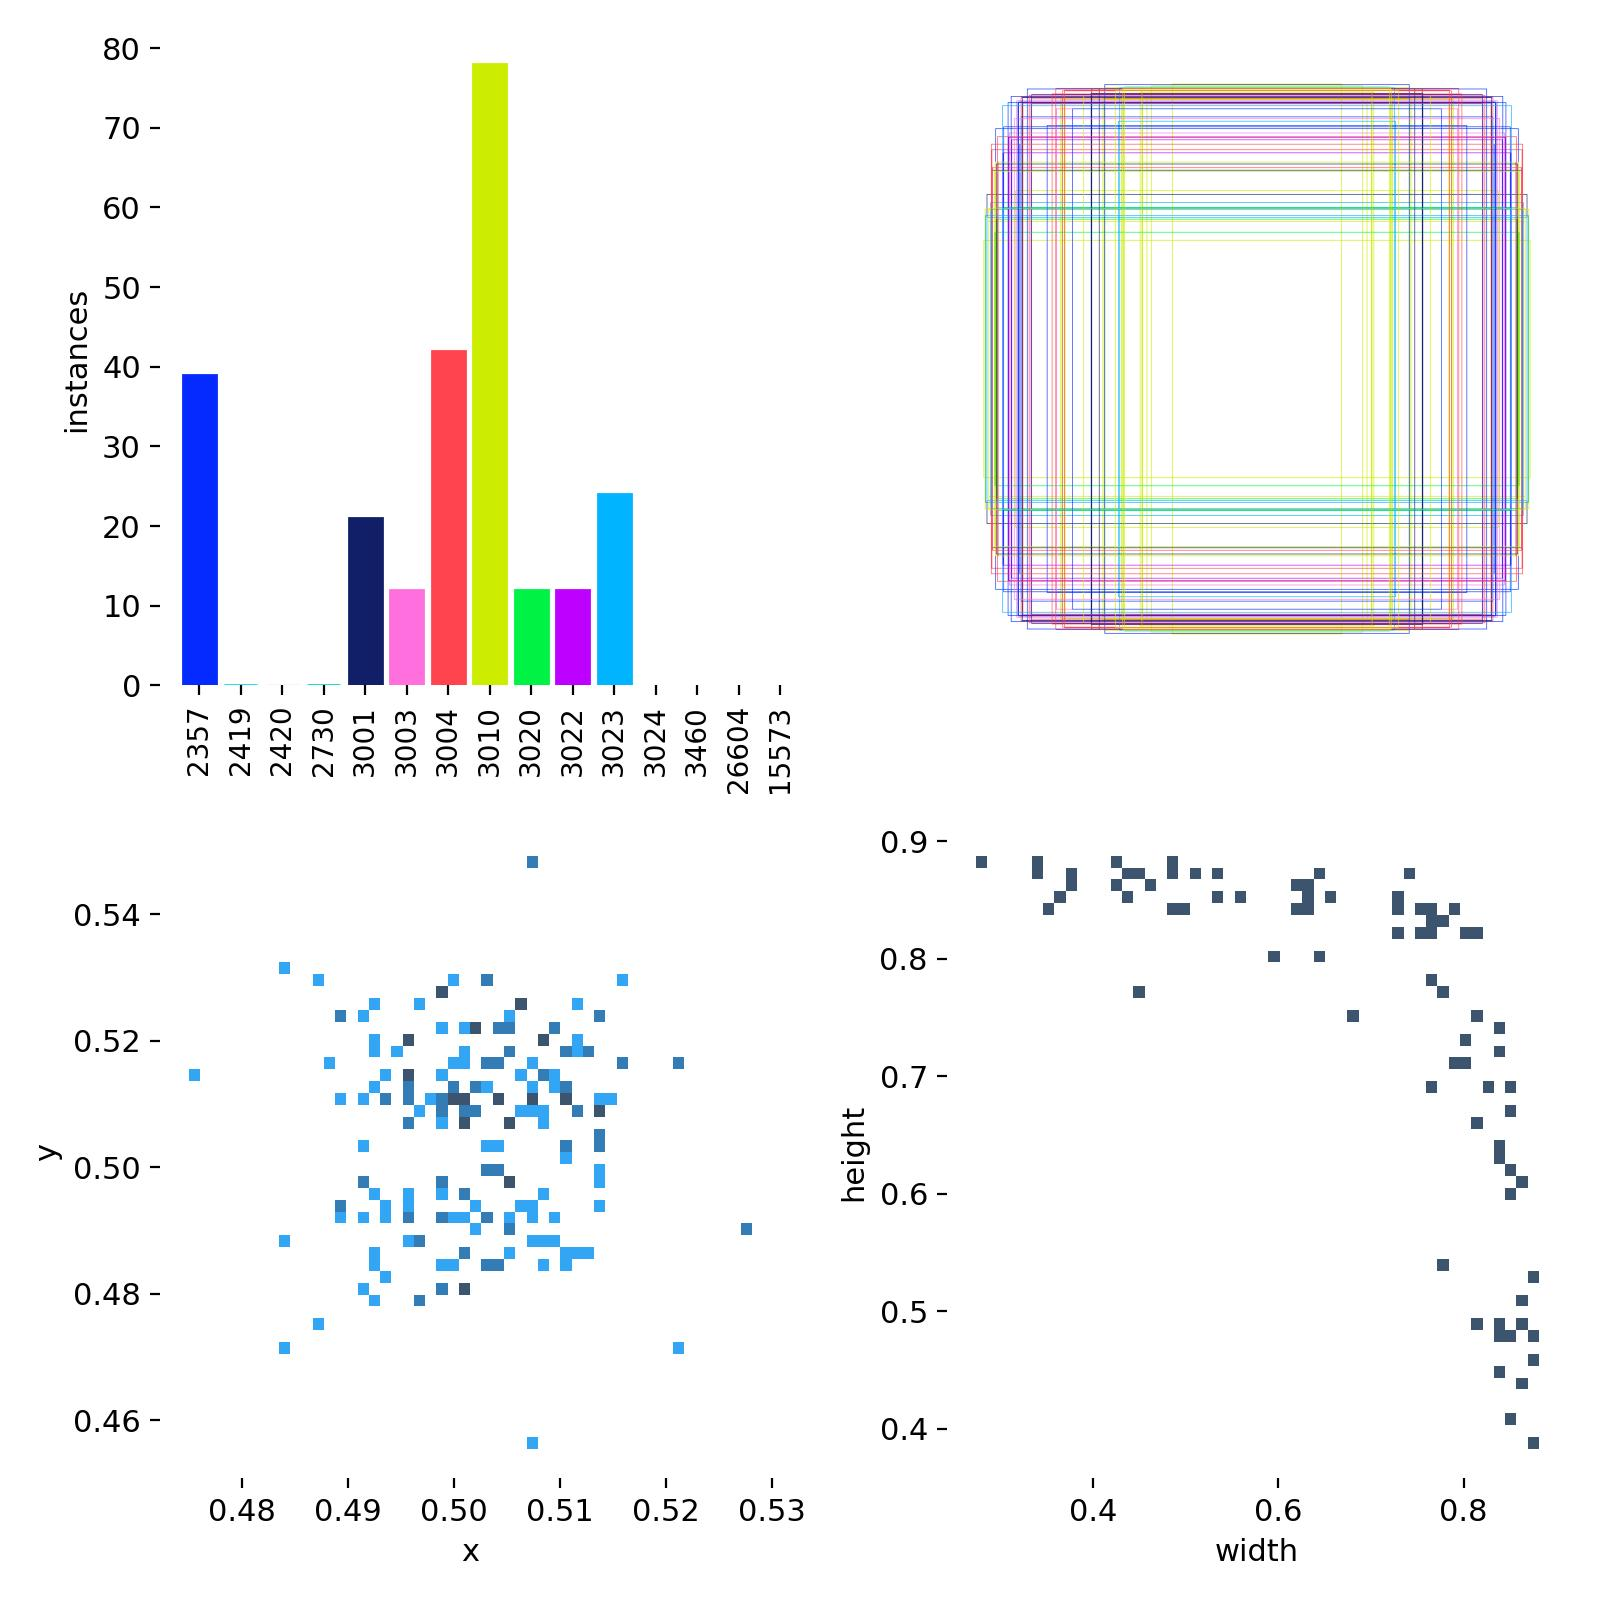

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train4/labels.jpg')

In [ ]:
!zip -r /content/runs.zip /content/runs

  adding: content/runs/ (stored 0%)
  adding: content/runs/detect/ (stored 0%)
  adding: content/runs/detect/predict7/ (stored 0%)
  adding: content/runs/detect/predict7/kU4nq5M.jpg (deflated 2%)
  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/P_curve.png (deflated 11%)
  adding: content/runs/detect/train/val_batch1_labels.jpg (deflated 27%)
  adding: content/runs/detect/train/val_batch1_pred.jpg (deflated 26%)
  adding: content/runs/detect/train/weights/ (stored 0%)
  adding: content/runs/detect/train/weights/best.pt (deflated 8%)
  adding: content/runs/detect/train/weights/last.pt (deflated 8%)
  adding: content/runs/detect/train/train_batch1.jpg (deflated 25%)
  adding: content/runs/detect/train/args.yaml (deflated 53%)
  adding: content/runs/detect/train/confusion_matrix_normalized.png (deflated 18%)
  adding: content/runs/detect/train/labels_correlogram.jpg (deflated 45%)
  adding: content/runs/detect/train/results.csv (deflated 54%)
  adding: 

In [ ]:
from google.colab import files
files.download("/content/runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>